In [1]:
# imports 
import numpy as np 
import pandas as pd 
import pingouin as pg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import warnings
import glob
import os
import h5_utilities_module as h5u
from tqdm import tqdm as tqdm
import statsmodels.api as sm
from scipy import stats
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)
from scipy.stats import f as f_dist
from scipy.signal import find_peaks

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

        nanmean_result = np.nanmean(bootstrap_means, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)


def arima_preprocess_trials(in_data, arima_params=(10, 2, 2)):
   """
   Apply ARIMA preprocessing to all trials of a time series.
   
   Parameters:
   -----------
   in_data: array [n_trials x n_times] - time series data
   arima_params: tuple - (p, d, q) ARIMA order
   
   Returns:
   --------
   whitened_data: array [n_trials x n_times] - ARIMA residuals or original data
   success_mask: array [n_trials] - boolean mask indicating ARIMA success per trial
   """
   
   n_trials, n_times = in_data.shape
   whitened_data = np.full((n_trials, n_times), np.nan)
   success_mask = np.zeros(n_trials, dtype=bool)
   
   for t in tqdm(range(n_trials)):
       try:
           model = ARIMA(in_data[t, :], order=arima_params)
           fitted = model.fit()
           whitened_data[t, :] = fitted.resid
           success_mask[t] = True
           
       except Exception:
           # Use original data if ARIMA fails
           whitened_data[t, :] = in_data[t, :]
           success_mask[t] = False
   
   return whitened_data, success_mask



def transmission_analysis(data_A, data_B, lags, time_step, win_size):
    """
    Perform sliding window transmission analysis between two neural time series.

    Tests directional predictive relationships by applying lagged regression analysis
    within sliding temporal windows. Based on the approach described in Crowe et al. 
    (2013) Nature Neuroscience for detecting information transmission between brain areas.

    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
        Neural data from brain area A (e.g., posterior probabilities from decoding).
        Should be preprocessed (e.g., ARIMA whitened) to remove autocorrelation.
    data_B : ndarray, shape (n_trials, n_times)  
        Neural data from brain area B, same format as data_A.
    lags : array_like
        Lag values to test (in time bins). Should start from 0.
        e.g., np.arange(0, 9) tests lags 0-8 bins.
    time_step : float
        Time duration of each bin in milliseconds (e.g., 25.0 for 25ms bins).
    win_size : float  
        Sliding window size in milliseconds (e.g., 500.0 for 500ms windows).
        
    Returns
    -------
    a2b_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area A predicts area B at each lag and time step.
        Higher values indicate stronger predictive relationships.
    b2a_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area B predicts area A at each lag and time step.
    bin_centers : ndarray, shape (n_time_steps,)
        Indices of original time bins corresponding to the center of each sliding window.
        Maps columns in a2b_f/b2a_f back to original data time points. 
    """

    n_samples = int(win_size / time_step)  # Convert to integer
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1  # Number of valid window positions
    
    # Initialize result arrays [n_lags x n_times]
    a2b_f = np.full((len(lags), n_time_steps), np.nan)
    b2a_f = np.full((len(lags), n_time_steps), np.nan)
    
    # Calculate bin centers for each window position
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over valid window positions
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
       
        # Extract windows from all trials
        a_window = data_A[:, window_start:window_end]  # [trials x window_bins]
        b_window = data_B[:, window_start:window_end]  # [trials x window_bins]
       
        for lag_ix, this_lag in enumerate(lags):
           
            # Test A -> B
            if this_lag > 0:
                a_pred = a_window[:, :-this_lag].flatten()  # Earlier A values
                b_targ = b_window[:, this_lag:].flatten()   # Later B values
            else:
                a_pred = a_window.flatten()
                b_targ = b_window.flatten()
               
            # Test B -> A 
            if this_lag > 0:
                b_pred = b_window[:, :-this_lag].flatten()  # Earlier B values
                a_targ = a_window[:, this_lag:].flatten()   # Later A values
            else:
                b_pred = b_window.flatten()
                a_targ = a_window.flatten()
           
            # Run regressions and compute F-statistics
            if len(a_pred) > 10:  # Minimum data check
                try:
                    X = sm.add_constant(a_pred)
                    model = sm.OLS(b_targ, X).fit()
                    a2b_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
                   
            if len(b_pred) > 10:
                try:
                    X = sm.add_constant(b_pred)  
                    model = sm.OLS(a_targ, X).fit()
                    b2a_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
               
    return a2b_f, b2a_f, bin_centers


def get_traj_speed_and_variance(trial_data, std_window=5, ts=None):
    """
    Calculate trajectory speed and variance for a single trial in 4D decoder space.
    
    Parameters:
    -----------
    trial_data : array, shape (n_times, 4)
        Posterior probabilities for the 4 decoder classes across time
    std_window : int
        Number of samples for sliding window standard deviation
    ts : array, optional
        Time points corresponding to each sample
        
    Returns:
    --------
    traj_speed : array, shape (n_times-1,)
        Euclidean speed (distance/time) between consecutive time points
    traj_std : array, shape (n_times-std_window+1,)
        Sliding window standard deviation of speed
    traj_speed_ts : array, shape (n_times-1,)
        Time points for speed measurements (midpoints between original samples)
    traj_std_ts : array, shape (n_times-std_window+1,)
        Time points for standard deviation measurements
    """
    n_times, n_classes = trial_data.shape
    
    # Calculate Euclidean distances between consecutive time points
    # This is the "speed" in the  decoder space
    diff_vectors = np.diff(trial_data, axis=0)  # shape: (n_times-1, 4)
    traj_speed = np.linalg.norm(diff_vectors, axis=1)  # shape: (n_times-1,)
    
    # Calculate sliding window standard deviation of speed
    # This captures local volatility in trajectory speed
    if len(traj_speed) < std_window:
        traj_std = np.array([np.std(traj_speed)])
        if ts is not None:
            traj_std_ts = np.array([ts[std_window//2]])
        else:
            traj_std_ts = np.array([std_window//2])
    else:
        traj_std = np.array([
            np.std(traj_speed[i:i+std_window]) 
            for i in range(len(traj_speed) - std_window + 1)
        ])
        
    # Generate time points for outputs
    if ts is not None:
        # Speed time points are midpoints between consecutive samples
        traj_speed_ts = (ts[:-1] + ts[1:]) / 2
        
        # Std time points are centered on the sliding window
        traj_std_ts = np.array([
            np.mean(traj_speed_ts[i:i+std_window])
            for i in range(len(traj_speed) - std_window + 1)
        ])
    else:
        traj_speed_ts = np.arange(len(traj_speed)) + 0.5
        traj_std_ts = np.arange(len(traj_std)) + std_window//2
    
    return traj_speed, traj_std, traj_speed_ts, traj_std_ts


def baseline_correct(data, baseline_idx):
    """
    Subtract the mean of baseline period from entire trace.
    Works with both 1D and 2D arrays.
    
    Parameters
    ----------
    data : ndarray
        Shape (n_trials, n_times) or (n_times,)
    baseline_idx : slice or array
        Indices defining the baseline period
        
    Returns
    -------
    data_corrected : ndarray
        Same shape as input, baseline-corrected
    """
    if data.ndim == 1:
        # 1D case
        baseline_mean = np.nanmean(data[baseline_idx])
        return data - baseline_mean
    else:
        # 2D case: compute baseline mean for each trial
        baseline_mean = np.nanmean(data[:, baseline_idx], axis=1, keepdims=True)
        return data - baseline_mean
    


def granger_causality_analysis(data_A, data_B, max_lag, time_step, win_size):
    """
    Perform sliding window Granger causality analysis.
    
    Tests whether past values of A help predict B beyond what B's own past predicts.
    
    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
    data_B : ndarray, shape (n_trials, n_times)
    max_lag : int
        Maximum number of lags to include (e.g., 8 for ~200ms if bins are 25ms)
    time_step : float
        Time duration of each bin in milliseconds
    win_size : float
        Sliding window size in milliseconds
        
    Returns
    -------
    a2b_f : ndarray, shape (n_time_steps,)
        F-statistics testing A→B causality (does A's past predict B?)
    b2a_f : ndarray, shape (n_time_steps,)
        F-statistics testing B→A causality (does B's past predict A?)
    a2b_p : ndarray, shape (n_time_steps,)
        P-values for A→B causality
    b2a_p : ndarray, shape (n_time_steps,)
        P-values for B→A causality
    bin_centers : ndarray, shape (n_time_steps,)
    """
    n_samples = int(win_size / time_step)
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1
    
    # Initialize result arrays
    a2b_f = np.full(n_time_steps, np.nan)
    b2a_f = np.full(n_time_steps, np.nan)
    a2b_p = np.full(n_time_steps, np.nan)
    b2a_p = np.full(n_time_steps, np.nan)
    
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over windows
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
        
        a_window = data_A[:, window_start:window_end]
        b_window = data_B[:, window_start:window_end]
        
        # Need enough data points for lags
        if n_samples <= max_lag + 1:
            continue
            
        try:
            # Test A → B (does A's past help predict B beyond B's own past?)
            
            # Create lagged predictors
            # B(t) is the target, we predict it from:
            # - B(t-1), B(t-2), ..., B(t-max_lag)  [B's own past]
            # - A(t-1), A(t-2), ..., A(t-max_lag)  [A's past]
            
            n_obs = n_samples - max_lag
            
            # Target: B at time t (from max_lag onwards)
            b_target = b_window[:, max_lag:].flatten()
            
            # Restricted model: B's own past only
            b_past = np.column_stack([
                b_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Full model: B's past + A's past
            a_past = np.column_stack([
                a_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Fit restricted model: B(t) ~ B(t-1) + ... + B(t-max_lag)
            X_restricted = sm.add_constant(b_past)
            model_restricted = sm.OLS(b_target, X_restricted).fit()
            
            # Fit full model: B(t) ~ B(t-1) + ... + A(t-1) + ...
            X_full = sm.add_constant(np.column_stack([b_past, a_past]))
            model_full = sm.OLS(b_target, X_full).fit()
            
            # F-test: does full model fit significantly better?
            # F = ((RSS_restricted - RSS_full) / num_added_params) / (RSS_full / df_full)
            rss_restricted = model_restricted.ssr
            rss_full = model_full.ssr
            df_full = model_full.df_resid
            num_added = max_lag  # Added A's lags
            
            f_stat = ((rss_restricted - rss_full) / num_added) / (rss_full / df_full)
            
            # P-value from F-distribution
            from scipy.stats import f as f_dist
            p_val = 1 - f_dist.cdf(f_stat, num_added, df_full)
            
            a2b_f[t_ix] = f_stat
            a2b_p[t_ix] = p_val
            
        except:
            pass
        
        try:
            # Test B → A (does B's past help predict A beyond A's own past?)
            a_target = a_window[:, max_lag:].flatten()
            
            a_past = np.column_stack([
                a_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            b_past = np.column_stack([
                b_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Restricted: A(t) ~ A's past only
            X_restricted = sm.add_constant(a_past)
            model_restricted = sm.OLS(a_target, X_restricted).fit()
            
            # Full: A(t) ~ A's past + B's past
            X_full = sm.add_constant(np.column_stack([a_past, b_past]))
            model_full = sm.OLS(a_target, X_full).fit()
            
            rss_restricted = model_restricted.ssr
            rss_full = model_full.ssr
            df_full = model_full.df_resid
            num_added = max_lag
            
            f_stat = ((rss_restricted - rss_full) / num_added) / (rss_full / df_full)
            p_val = 1 - f_dist.cdf(f_stat, num_added, df_full)
            
            b2a_f[t_ix] = f_stat
            b2a_p[t_ix] = p_val
            
        except:
            pass
    
    return a2b_f, b2a_f, a2b_p, b2a_p, bin_centers


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output\D20231219_Rec05_decoder.h5':
CdN_acc_mean
CdN_all_dir_pp
CdN_alt_ch
CdN_alt_unch
CdN_ch
CdN_ch_dir_pp
CdN_dir_acc
CdN_pp
CdN_unch
CdN_unch_dir_pp
OFC_acc_mean
OFC_all_dir_pp
OFC_alt_ch
OFC_alt_unch
OFC_ch
OFC_ch_dir_pp
OFC_dir_acc
OFC_pp
OFC_unch
OFC_unch_dir_pp
bhv
ts


In [5]:
# initialize lists to accumulate data into
OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []
CdN_ch = []
CdN_unch = []
CdN_alt_ch = []
CdN_alt_unch = []
bhv = pd.DataFrame()
OFC_acc = []
CdN_acc = []
subject = []
session = []
OFC_cue_pp = []


# accumulate data from each file

for f_num, this_file in enumerate(data_files):
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*s)
    session.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*f_num)

    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    
    OFC_ch.append(h5u.pull_from_h5(this_file, 'OFC_ch'))
    OFC_unch.append(h5u.pull_from_h5(this_file, 'OFC_unch'))
    OFC_alt_ch.append(h5u.pull_from_h5(this_file, 'OFC_alt_ch'))
    OFC_alt_unch.append(h5u.pull_from_h5(this_file, 'OFC_alt_unch'))
    
    CdN_ch.append(h5u.pull_from_h5(this_file, 'CdN_ch'))
    CdN_unch.append(h5u.pull_from_h5(this_file, 'CdN_unch'))
    CdN_alt_ch.append(h5u.pull_from_h5(this_file, 'CdN_alt_ch'))
    CdN_alt_unch.append(h5u.pull_from_h5(this_file, 'CdN_alt_unch'))
    
    OFC_acc.append(h5u.pull_from_h5(this_file, 'OFC_acc_mean'))
    CdN_acc.append(h5u.pull_from_h5(this_file, 'CdN_acc_mean'))
    
    ts = h5u.pull_from_h5(this_file, 'ts')
    
    
# convert everything back to arrays
subject = np.concatenate(subject, axis=0)
session = np.concatenate(session, axis=0)

OFC_ch = np.concatenate(OFC_ch, axis=0)
OFC_unch = np.concatenate(OFC_unch, axis=0)
OFC_alt_ch = np.concatenate(OFC_alt_ch, axis=0)
OFC_alt_unch = np.concatenate(OFC_alt_unch, axis=0)

CdN_ch = np.concatenate(CdN_ch, axis=0)
CdN_unch = np.concatenate(CdN_unch, axis=0)
CdN_alt_ch = np.concatenate(CdN_alt_ch, axis=0)
CdN_alt_unch = np.concatenate(CdN_alt_unch, axis=0)

OFC_acc = np.concatenate(OFC_acc, axis=0)
CdN_acc = np.concatenate(CdN_acc, axis=0)

In [6]:
n_trials = len(bhv)

# initialize empty arrays
ofc_traj = np.zeros((n_trials, len(ts), 4))
cdn_traj = np.zeros((n_trials, len(ts), 4))

# put the posteriors into single arrays for trajectory analysis
win = 2
ofc_traj[:,:,0] = moving_average(OFC_ch, win, axis = 1)
ofc_traj[:,:,1] = moving_average(OFC_unch, win, axis = 1)
ofc_traj[:,:,2] = moving_average(OFC_alt_ch, win, axis = 1)
ofc_traj[:,:,3] = moving_average(OFC_alt_unch, win, axis = 1)

cdn_traj[:,:,0] = moving_average(CdN_ch, win, axis = 1)
cdn_traj[:,:,1] = moving_average(CdN_unch, win, axis = 1)
cdn_traj[:,:,2] = moving_average(CdN_alt_ch, win, axis = 1)
cdn_traj[:,:,3] = moving_average(CdN_alt_unch, win, axis = 1)

In [7]:
# calculate speeds of just the 2d trajectories
reduced_ofc_traj = np.stack((ofc_traj[:,:,0], ofc_traj[:,:,3]), axis=2)
reduced_cdn_traj = np.stack((cdn_traj[:,:,0], cdn_traj[:,:,3]), axis=2)

In [8]:

# Pre-allocate arrays for trajectory analysis
n_trials = ofc_traj.shape[0]
n_times = ofc_traj.shape[1]
std_window = 5

# Calculate expected output sizes
speed_len = n_times - 1  # diff reduces by 1
std_len = n_times - std_window  

# Pre-allocate arrays
ofc_speed = np.zeros((n_trials, speed_len))
ofc_std = np.zeros((n_trials, std_len))
cdn_speed = np.zeros((n_trials, speed_len)) 
cdn_std = np.zeros((n_trials, std_len))

# Calculate time vectors once
speed_ts = (ts[:-1] + ts[1:]) / 2
std_ts = np.array([
    np.mean(speed_ts[i:i+std_window])
    for i in range(len(speed_ts) - std_window + 1)
])

# Now calculate the trajectory speeds and variances for each single trial
for t in tqdm(range(ofc_traj.shape[0])):

    ofc_speed[t,:], ofc_std[t,:], _, _ = get_traj_speed_and_variance(reduced_ofc_traj[t,:,:], std_window=std_window, ts=ts)
    cdn_speed[t,:], cdn_std[t,:], _, _ = get_traj_speed_and_variance(reduced_cdn_traj[t,:,:], std_window=std_window, ts=ts)


# truncate the data for the next step
start_ix = np.argmin(np.abs(speed_ts - -500))
end_ix = np.argmin(np.abs(speed_ts - 700))
ofc_speed = ofc_speed[:, start_ix: end_ix]
ofc_std = ofc_std[:, start_ix: end_ix]
cdn_speed = cdn_speed[:, start_ix: end_ix]
cdn_std = cdn_std[:, start_ix: end_ix]
speed_ts = speed_ts[start_ix: end_ix]

100%|██████████| 8825/8825 [00:12<00:00, 682.97it/s]


In [9]:
# Z-score based on PRE-stimulus baseline
z_ofc_speed = np.zeros_like(ofc_speed)
z_ofc_std = np.zeros_like(ofc_std)
z_cdn_speed = np.zeros_like(cdn_speed)
z_cdn_std = np.zeros_like(cdn_std)

# Define baseline epoch (e.g., -200 to 0 ms before picture onset)
baseline_start = np.argmin(np.abs(speed_ts - (-500)))
baseline_end = np.argmin(np.abs(speed_ts - 0))

for s in np.unique(session):
    s_ix = session == s
    
    # Get the data for this session
    ofc_session = ofc_speed[s_ix, :]
    cdn_session = cdn_speed[s_ix, :]
    
    # Compute mean and std from BASELINE period
    ofc_mean = np.mean(ofc_session[:, baseline_start:baseline_end])
    ofc_std_val = np.std(ofc_session[:, baseline_start:baseline_end])
    
    cdn_mean = np.mean(cdn_session[:, baseline_start:baseline_end])
    cdn_std_val = np.std(cdn_session[:, baseline_start:baseline_end])
    
    # Apply z-scoring to entire time series
    z_ofc_speed[s_ix, :] = (ofc_session - ofc_mean) / ofc_std_val
    z_cdn_speed[s_ix, :] = (cdn_session - cdn_mean) / cdn_std_val
    
    # Same for distance from manifold
    ofc_std_session = ofc_std[s_ix, :]
    cdn_std_session = cdn_std[s_ix, :]
    
    ofc_std_mean = np.mean(ofc_std_session[:, baseline_start:baseline_end])
    ofc_std_std = np.std(ofc_std_session[:, baseline_start:baseline_end])
    
    cdn_std_mean = np.mean(cdn_std_session[:, baseline_start:baseline_end])
    cdn_std_std = np.std(cdn_std_session[:, baseline_start:baseline_end])
    
    z_ofc_std[s_ix, :] = (ofc_std_session - ofc_std_mean) / ofc_std_std
    z_cdn_std[s_ix, :] = (cdn_std_session - cdn_std_mean) / cdn_std_std

In [10]:
# create indices for each subject
d_ix = subject == 0
k_ix = subject == 1

# create indices for the single and double saccade trials
single_ix = (bhv['n_sacc'] == 1) & (bhv['state'] < 3)
double_ix = (bhv['n_sacc'] == 2) & (bhv['state'] < 3)

# baseline correct each condition
baseline_ix = slice(baseline_start, baseline_end)
z_ofc_speed[k_ix & single_ix, :] = baseline_correct(z_ofc_speed[k_ix & single_ix, :], baseline_ix)
z_ofc_speed[k_ix & double_ix, :] = baseline_correct(z_ofc_speed[k_ix & double_ix, :], baseline_ix)
z_ofc_speed[d_ix & single_ix, :] = baseline_correct(z_ofc_speed[d_ix & single_ix, :], baseline_ix)
z_ofc_speed[d_ix & double_ix, :] = baseline_correct(z_ofc_speed[d_ix & double_ix, :], baseline_ix)

z_ofc_std[k_ix & single_ix, :] = baseline_correct(z_ofc_std[k_ix & single_ix, :], baseline_ix)
z_ofc_std[k_ix & double_ix, :] = baseline_correct(z_ofc_std[k_ix & double_ix, :], baseline_ix)
z_ofc_std[d_ix & single_ix, :] = baseline_correct(z_ofc_std[d_ix & single_ix, :], baseline_ix)
z_ofc_std[d_ix & double_ix, :] = baseline_correct(z_ofc_std[d_ix & double_ix, :], baseline_ix)

z_cdn_speed[k_ix & single_ix, :] = baseline_correct(z_cdn_speed[k_ix & single_ix, :], baseline_ix)
z_cdn_speed[k_ix & double_ix, :] = baseline_correct(z_cdn_speed[k_ix & double_ix, :], baseline_ix)
z_cdn_speed[d_ix & single_ix, :] = baseline_correct(z_cdn_speed[d_ix & single_ix, :], baseline_ix)
z_cdn_speed[d_ix & double_ix, :] = baseline_correct(z_cdn_speed[d_ix & double_ix, :], baseline_ix)

z_cdn_std[k_ix & single_ix, :] = baseline_correct(z_cdn_std[k_ix & single_ix, :], baseline_ix)
z_cdn_std[k_ix & double_ix, :] = baseline_correct(z_cdn_std[k_ix & double_ix, :], baseline_ix)
z_cdn_std[d_ix & single_ix, :] = baseline_correct(z_cdn_std[d_ix & single_ix, :], baseline_ix)
z_cdn_std[d_ix & double_ix, :] = baseline_correct(z_cdn_std[d_ix & double_ix, :], baseline_ix)

In [11]:

s_win = 4
s_ofc_speed = moving_average(z_ofc_speed, s_win, axis=1)
s_ofc_std = moving_average(z_ofc_std, s_win, axis=1)
s_cdn_speed = moving_average(z_cdn_speed, s_win, axis=1)
s_cdn_std = moving_average(z_cdn_std, s_win, axis=1)


# prepare for plotting
k_1_ofc_speed_mean, k_1_ofc_speed_ci = calculate_mean_and_interval(s_ofc_speed[k_ix & single_ix,:], type='bootstrap')
k_2_ofc_speed_mean, k_2_ofc_speed_ci = calculate_mean_and_interval(s_ofc_speed[k_ix & double_ix,:], type='bootstrap')
k_1_ofc_std_mean, k_1_ofc_std_ci = calculate_mean_and_interval(s_ofc_std[k_ix & single_ix,:], type='bootstrap')
k_2_ofc_std_mean, k_2_ofc_std_ci = calculate_mean_and_interval(s_ofc_std[k_ix & double_ix,:], type='bootstrap')

k_1_cdn_speed_mean, k_1_cdn_speed_ci = calculate_mean_and_interval(s_cdn_speed[k_ix & single_ix,:], type='bootstrap')
k_2_cdn_speed_mean, k_2_cdn_speed_ci = calculate_mean_and_interval(s_cdn_speed[k_ix & double_ix,:], type='bootstrap')
k_1_cdn_std_mean, k_1_cdn_std_ci = calculate_mean_and_interval(s_cdn_std[k_ix & single_ix,:], type='bootstrap')
k_2_cdn_std_mean, k_2_cdn_std_ci = calculate_mean_and_interval(s_cdn_std[k_ix & double_ix,:], type='bootstrap')

d_1_ofc_speed_mean, d_1_ofc_speed_ci = calculate_mean_and_interval(s_ofc_speed[d_ix & single_ix,:], type='bootstrap')
d_2_ofc_speed_mean, d_2_ofc_speed_ci = calculate_mean_and_interval(s_ofc_speed[d_ix & double_ix,:], type='bootstrap')
d_1_ofc_std_mean, d_1_ofc_std_ci = calculate_mean_and_interval(s_ofc_std[d_ix & single_ix,:], type='bootstrap')
d_2_ofc_std_mean, d_2_ofc_std_ci = calculate_mean_and_interval(s_ofc_std[d_ix & double_ix,:], type='bootstrap')

d_1_cdn_speed_mean, d_1_cdn_speed_ci = calculate_mean_and_interval(s_cdn_speed[d_ix & single_ix,:], type='bootstrap')
d_2_cdn_speed_mean, d_2_cdn_speed_ci = calculate_mean_and_interval(s_cdn_speed[d_ix & double_ix,:], type='bootstrap')
d_1_cdn_std_mean, d_1_cdn_std_ci = calculate_mean_and_interval(s_cdn_std[d_ix & single_ix,:], type='bootstrap')
d_2_cdn_std_mean, d_2_cdn_std_ci = calculate_mean_and_interval(s_cdn_std[d_ix & double_ix,:], type='bootstrap')

Text(0.5, 0, 'Time from Pics On (ms)')

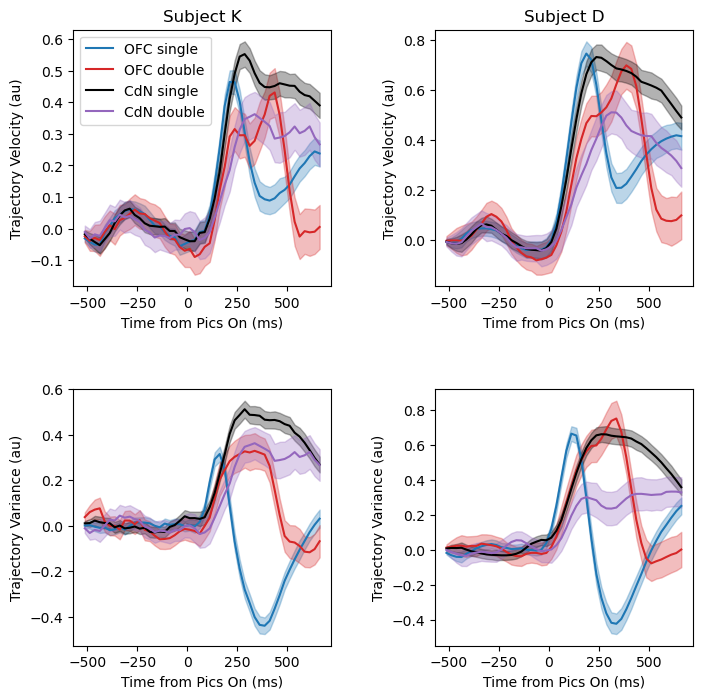

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ofc_1_col = 'tab:blue'
ofc_2_col = 'tab:red'

cdn_1_col = 'black'
cdn_2_col = 'tab:purple'

ax[0,0].fill_between(speed_ts, d_1_ofc_speed_mean - d_1_ofc_speed_ci, d_1_ofc_speed_mean + d_1_ofc_speed_ci, color=ofc_1_col, alpha = .3)
ax[0,0].plot(speed_ts, d_1_ofc_speed_mean, color=ofc_1_col, label = 'OFC single')
ax[0,0].fill_between(speed_ts, d_2_ofc_speed_mean - d_2_ofc_speed_ci, d_2_ofc_speed_mean + d_2_ofc_speed_ci, color=ofc_2_col, alpha = .3)
ax[0,0].plot(speed_ts, d_2_ofc_speed_mean, color=ofc_2_col, label = 'OFC double')
ax[0,0].fill_between(speed_ts, d_1_cdn_speed_mean - d_1_cdn_speed_ci, d_1_cdn_speed_mean + d_1_cdn_speed_ci, color=cdn_1_col, alpha = .3)
ax[0,0].plot(speed_ts, d_1_cdn_speed_mean, color=cdn_1_col, label = 'CdN single')
ax[0,0].fill_between(speed_ts, d_2_cdn_speed_mean - d_2_cdn_speed_ci, d_2_cdn_speed_mean + d_2_cdn_speed_ci, color=cdn_2_col, alpha = .3)
ax[0,0].plot(speed_ts, d_2_cdn_speed_mean, color=cdn_2_col, label = 'CdN double')
ax[0,0].set_ylabel('Trajectory Velocity (au)')
ax[0,0].set_xlabel('Time from Pics On (ms)')
ax[0,0].legend()
ax[0,0].set_title('Subject K')

ax[1,0].fill_between(speed_ts, k_1_ofc_speed_mean - k_1_ofc_speed_ci, k_1_ofc_speed_mean + k_1_ofc_speed_ci, color=ofc_1_col, alpha = .3)
ax[1,0].plot(speed_ts, k_1_ofc_speed_mean, color=ofc_1_col)
ax[1,0].fill_between(speed_ts, k_2_ofc_speed_mean - k_2_ofc_speed_ci, k_2_ofc_speed_mean + k_2_ofc_speed_ci, color=ofc_2_col, alpha = .3)
ax[1,0].plot(speed_ts, k_2_ofc_speed_mean, color=ofc_2_col)
ax[1,0].fill_between(speed_ts, k_1_cdn_speed_mean - k_1_cdn_speed_ci, k_1_cdn_speed_mean + k_1_cdn_speed_ci, color=cdn_1_col, alpha = .3)
ax[1,0].plot(speed_ts, k_1_cdn_speed_mean, color=cdn_1_col)
ax[1,0].fill_between(speed_ts, d_2_cdn_speed_mean - d_2_cdn_speed_ci, d_2_cdn_speed_mean + d_2_cdn_speed_ci, color=cdn_2_col, alpha = .3)
ax[1,0].plot(speed_ts, d_2_cdn_speed_mean, color=cdn_2_col)
ax[1,0].set_ylabel('Trajectory Variance (au)')
ax[1,0].set_xlabel('Time from Pics On (ms)')


ax[0,1].fill_between(speed_ts, d_1_ofc_std_mean - d_1_ofc_std_ci, d_1_ofc_std_mean + d_1_ofc_std_ci, color=ofc_1_col, alpha = .3)
ax[0,1].plot(speed_ts, d_1_ofc_std_mean, color=ofc_1_col)
ax[0,1].fill_between(speed_ts, d_2_ofc_std_mean - d_2_ofc_std_ci, d_2_ofc_std_mean + d_2_ofc_std_ci, color=ofc_2_col, alpha = .3)
ax[0,1].plot(speed_ts, d_2_ofc_std_mean, color=ofc_2_col)
ax[0,1].fill_between(speed_ts, d_1_cdn_std_mean - d_1_cdn_std_ci, d_1_cdn_std_mean + d_1_cdn_std_ci, color=cdn_1_col, alpha = .3)
ax[0,1].plot(speed_ts, d_1_cdn_std_mean, color=cdn_1_col)
ax[0,1].fill_between(speed_ts, d_2_cdn_std_mean - d_2_cdn_std_ci, d_2_cdn_std_mean + d_2_cdn_std_ci, color=cdn_2_col, alpha = .3)
ax[0,1].plot(speed_ts, d_2_cdn_std_mean, color=cdn_2_col)
ax[0,1].set_ylabel('Trajectory Velocity (au)')
ax[0,1].set_xlabel('Time from Pics On (ms)')
ax[0,1].set_title('Subject D')



ax[1,1].fill_between(speed_ts, k_1_ofc_std_mean - k_1_ofc_std_ci, k_1_ofc_std_mean + k_1_ofc_std_ci, color=ofc_1_col, alpha = .3)
ax[1,1].plot(speed_ts, k_1_ofc_std_mean, color=ofc_1_col)
ax[1,1].fill_between(speed_ts, k_2_ofc_std_mean - k_2_ofc_std_ci, k_2_ofc_std_mean + k_2_ofc_std_ci, color=ofc_2_col, alpha = .3)
ax[1,1].plot(speed_ts, k_2_ofc_std_mean, color=ofc_2_col)
ax[1,1].fill_between(speed_ts, k_1_cdn_std_mean - k_1_cdn_std_ci, k_1_cdn_std_mean + k_1_cdn_std_ci, color=cdn_1_col, alpha = .3)
ax[1,1].plot(speed_ts, k_1_cdn_std_mean, color=cdn_1_col)
ax[1,1].fill_between(speed_ts, k_2_cdn_std_mean - k_2_cdn_std_ci, k_2_cdn_std_mean + k_2_cdn_std_ci, color=cdn_2_col, alpha = .3)
ax[1,1].plot(speed_ts, k_2_cdn_std_mean, color=cdn_2_col)
ax[1,1].set_ylabel('Trajectory Variance (au)')
ax[1,1].set_xlabel('Time from Pics On (ms)')


In [13]:

# let's look at mean trajectories
d_ofc_traj_mean_single = np.nanmean(ofc_traj[d_ix & single_ix, :,:], axis=0).T
d_ofc_traj_mean_double = np.nanmean(ofc_traj[d_ix & double_ix, :,:], axis=0).T
d_cdn_traj_mean_single = np.nanmean(cdn_traj[d_ix & single_ix, :,:], axis=0).T
d_cdn_traj_mean_double = np.nanmean(cdn_traj[d_ix & double_ix, :,:], axis=0).T

k_ofc_traj_mean_single = np.nanmean(ofc_traj[k_ix & single_ix, :,:], axis=0).T
k_ofc_traj_mean_double = np.nanmean(ofc_traj[k_ix & double_ix, :,:], axis=0).T
k_cdn_traj_mean_single = np.nanmean(cdn_traj[k_ix & single_ix, :,:], axis=0).T
k_cdn_traj_mean_double = np.nanmean(cdn_traj[k_ix & double_ix, :,:], axis=0).T

Text(0.5, 1.0, 'Subject K')

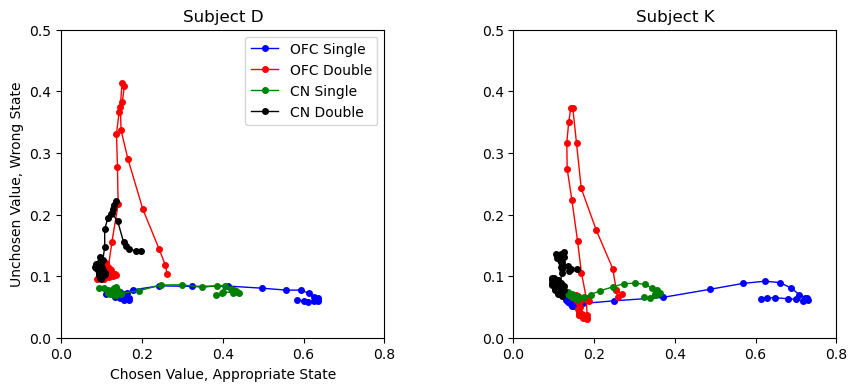

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ax[0].plot(d_ofc_traj_mean_single[0,20:61], d_ofc_traj_mean_single[3,20:61], 'b-', label='OFC Single', linewidth=1, marker='.', markersize = 8)
ax[0].plot(d_ofc_traj_mean_double[0,20:61], d_ofc_traj_mean_double[3,20:61], 'r-', label='OFC Double', linewidth=1, marker='.', markersize = 8)
ax[0].plot(d_cdn_traj_mean_single[0,20:61], d_cdn_traj_mean_single[3,20:61], 'g-', label='CN Single', linewidth=1, marker='.', markersize = 8)
ax[0].plot(d_cdn_traj_mean_double[0,20:61], d_cdn_traj_mean_double[3,20:61], 'k-', label='CN Double', linewidth=1, marker='.', markersize = 8)
ax[0].set_xlim((0, .8))
ax[0].set_ylim((0, .5))
ax[0].set_xlabel('Chosen Value, Appropriate State')
ax[0].set_ylabel('Unchosen Value, Wrong State')
ax[0].set_title('Subject D')
ax[0].legend()


ax[1].plot(k_ofc_traj_mean_single[0,20:61] - .1, k_ofc_traj_mean_single[3,20:61], 'b-', label='OFC Single', linewidth=1, marker='.', markersize = 8)
ax[1].plot(k_ofc_traj_mean_double[0,20:61], k_ofc_traj_mean_double[3,20:61], 'r-', label='OFC Single', linewidth=1, marker='.', markersize = 8)
ax[1].plot(k_cdn_traj_mean_single[0,20:61], k_cdn_traj_mean_single[3,20:61], 'g-', label='OFC Single', linewidth=1, marker='.', markersize = 8)
ax[1].plot(k_cdn_traj_mean_double[0,20:61], k_cdn_traj_mean_double[3,20:61], 'k-', label='OFC Single', linewidth=1, marker='.', markersize = 8)
ax[1].set_xlim((0, .8))
ax[1].set_ylim((0, .5))
ax[1].set_title('Subject K')